Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Validation | Acc: 1.0 | F1: 1.0
              precision    recall  f1-score   support

        High       1.00      1.00      1.00        60
         Low       1.00      1.00      1.00        70
      Medium       1.00      1.00      1.00        70

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

Test | Acc: 1.0 | F1: 1.0


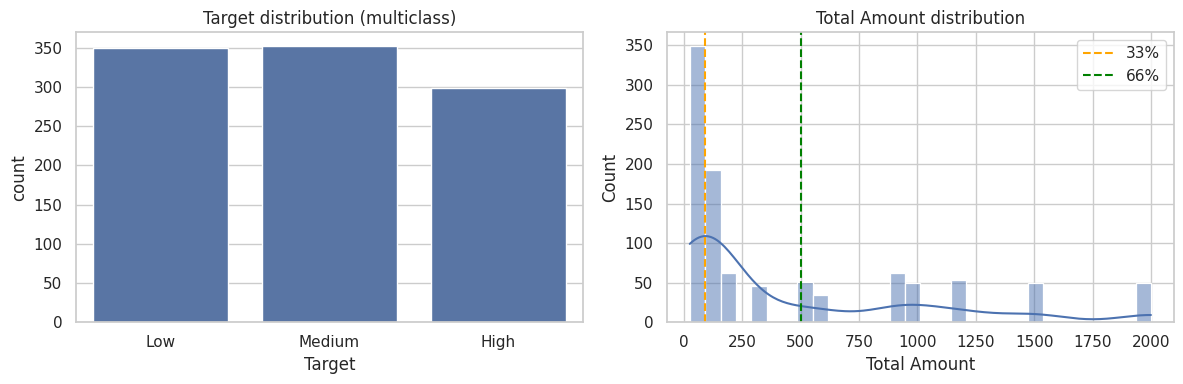

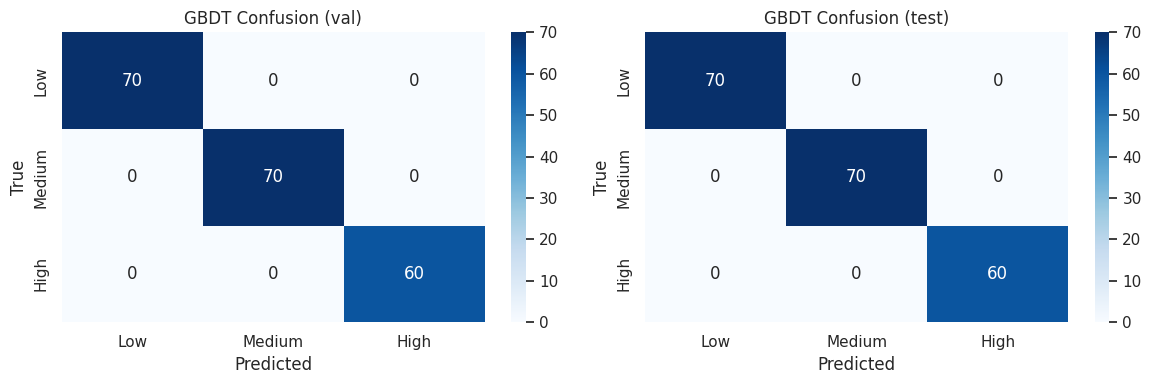

/tmp/ipython-input-3919126488.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=imp.values, y=imp.index, palette='magma')


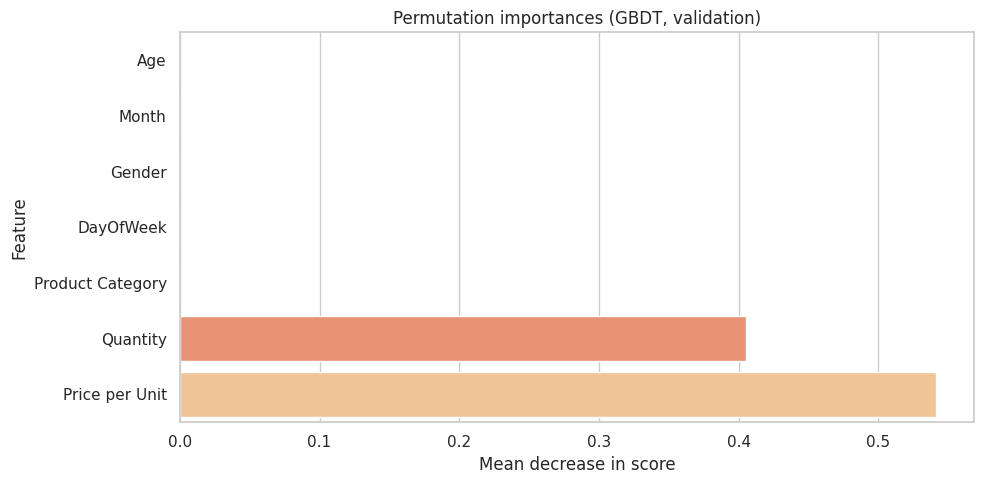

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance

drive.mount('/content/drive')
sns.set(style='whitegrid', context='notebook')
csv_path = "/content/drive/MyDrive/retail_sales_dataset.csv"
df = pd.read_csv(csv_path)
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
mode = 'multiclass'
if mode == 'binary':
    thr = df['Total Amount'].quantile(0.66)
    df['Target'] = (df['Total Amount'] > thr).astype(int)
else:
    q_low, q_high = df['Total Amount'].quantile([0.33, 0.66])
    df['Target'] = pd.cut(df['Total Amount'], bins=[-np.inf, q_low, q_high, np.inf],
                         labels=['Low', 'Medium', 'High'], include_lowest=True)
feature_num = ['Age', 'Quantity', 'Price per Unit', 'Month', 'DayOfWeek']
feature_cat = ['Gender', 'Product Category']
X = df[feature_num + feature_cat].copy()
y = df['Target'].copy()
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)
preprocess = ColumnTransformer([
    ('num', StandardScaler(), feature_num),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), feature_cat)
])
avg = 'binary' if mode == 'binary' else 'macro'
pipe = Pipeline(steps=[('prep', preprocess), ('clf', GradientBoostingClassifier(random_state=42))])
pipe.fit(X_train, y_train)
pred_val = pipe.predict(X_val)
pred_test = pipe.predict(X_test)
print('Validation | Acc:', accuracy_score(y_val, pred_val), '| F1:', f1_score(y_val, pred_val, average=avg))
print(classification_report(y_val, pred_val))
print('Test | Acc:', accuracy_score(y_test, pred_test), '| F1:', f1_score(y_test, pred_test, average=avg))
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
if mode == 'binary':
    sns.countplot(x=y, ax=axes[0])
    axes[0].set_title('Target distribution (binary)')
else:
    sns.countplot(x=y, order=['Low', 'Medium', 'High'], ax=axes[0])
    axes[0].set_title('Target distribution (multiclass)')
sns.histplot(df['Total Amount'], bins=30, kde=True, ax=axes[1])
axes[1].axvline(df['Total Amount'].quantile(0.33), color='orange', linestyle='--', label='33%')
axes[1].axvline(df['Total Amount'].quantile(0.66), color='green', linestyle='--', label='66%')
axes[1].set_title('Total Amount distribution')
axes[1].legend()
plt.tight_layout()
plt.show()
def plot_conf(ax, y_true, y_pred, title, labels=None):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=labels if labels else None,
                yticklabels=labels if labels else None)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(title)
labels = [0, 1] if mode == 'binary' else ['Low', 'Medium', 'High']
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_conf(axes[0], y_val, pred_val, 'GBDT Confusion (val)', labels)
plot_conf(axes[1], y_test, pred_test, 'GBDT Confusion (test)', labels)
plt.tight_layout()
plt.show()
original_feat_names = feature_num + feature_cat
scoring = 'f1' if mode == 'binary' else 'f1_macro'
perm = permutation_importance(pipe, X_val, y_val, n_repeats=10, random_state=42, scoring=scoring)
plt.figure(figsize=(10, 5))
imp = pd.Series(perm.importances_mean, index=original_feat_names)
imp.sort_values(inplace=True)
sns.barplot(x=imp.values, y=imp.index, palette='magma')
plt.title('Permutation importances (GBDT, validation)')
plt.xlabel('Mean decrease in score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()